# Setup

In [12]:
%reload_ext autoreload

In [8]:
%pwd

'/home/kpmurphy/github/shifty/shifty/label_shift'

In [9]:
%cd ..

/home/kpmurphy/github/shifty/shifty


In [10]:
%cd ..

/home/kpmurphy/github/shifty


In [28]:
#from shifty.label_shift.labelshift_lib import *
from shifty.label_shift.tta_gauss import *
from shifty.label_shift.logreg_flax import *

print(NurdParams) # check that one of the symbols is defiend

<class 'shifty.label_shift.tta_gauss.NurdParams'>


In [13]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [2]:
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# If you want to  assign 2 TPU cores per process,
# for both notebook and command line
#https://docs.google.com/document/d/1sbRFVSPePq_8oGBntSOmG0V5gqxyNiuDn-4_ph8eoBc/edit#heading=h.y89aert1620u

import os 
# 2x 2 chips (4 cores) per process:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,2,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0,1" # Change to "2,3" for the second machine
# Pick a unique port per process
os.environ["TPU_MESH_CONTROLLER_ADDRESS"] = "localhost:8476"
os.environ["TPU_MESH_CONTROLLER_PORT"] = "8476"

print('done')

In [37]:

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
import scipy.stats
import einops
from functools import partial

from functools import partial
from collections import namedtuple
import itertools
from itertools import repeat
from time import time
import chex
import typing
from typing import Any, Callable, Sequence

import jax
import jax.random as jr
import jax.numpy as jnp
from jax import vmap, grad, jit
from jax import lax, random, numpy as jnp
#import jax.debug

from flax.core import freeze, unfreeze
from flax import linen as nn
import flax

import jaxopt
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import torch
from torch.utils.data import TensorDataset, DataLoader

import distrax
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

#jax.config.update("jax_enable_x64", False)


import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression

In [66]:
import os 
cpu_count = os.cpu_count()
print(cpu_count)

# Run jax on multiple CPU cores
# https://github.com/google/jax/issues/5506
# https://stackoverflow.com/questions/72328521/jax-pmap-with-multi-core-cpu
import os 
#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=90'

import jax
print(jax.devices())

96
[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [64]:
# Scratch

In [65]:

def g(x, y):
    return x+y

xs = jnp.array([1,2])
ys = jnp.array([10,20])

gg = partial(g, y=ys)

zs = [gg(x) for x in xs]
print(zs)

zs = vmap(gg)(xs)
print(zs)

zs = jax.pmap(gg)(xs)
print(zs)

[DeviceArray([11, 21], dtype=int32), DeviceArray([12, 22], dtype=int32)]
[[11 21]
 [12 22]]
[[11 21]
 [12 22]]


In [58]:
def compare_method(optimizer, name=None, batch_size=ntrain, max_iter=500):
    if name is None:
        name = optimizer 
    key = jr.PRNGKey(0)
    model = LogReg(key, ndim, nclasses, max_iter=max_iter, l2reg=l2reg, optimizer=optimizer, batch_size=batch_size)  
    model.fit(X, y)
    probs = np.array(model.predict(X))
    print('method {:s}, max deviation from true probs {:.3f}'.format(name, np.max(true_probs - probs)))
    print('truth: ', true_probs[0])
    print('pred: ', probs[0])

In [59]:
compare_method("LBFGS")

/home/kpmurphy/mambaforge/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


method LBFGS, max deviation from true probs 0.008
truth:  [0.858 0.134 0.008]
pred:  [0.853 0.138 0.008]


In [60]:
compare_method(optax.adam(0.01), name="adam 0.01, bs=N", batch_size=ntrain)

method adam 0.01, bs=N, max deviation from true probs 0.164
truth:  [0.858 0.134 0.008]
pred:  [0.801 0.169 0.03 ]


In [61]:
compare_method(optax.adam(0.01), name="adam 0.01, bs=32", batch_size=32)

method adam 0.01, bs=32, max deviation from true probs 0.240
truth:  [0.858 0.134 0.008]
pred:  [0.77  0.186 0.044]


In [62]:
compare_method("polyak", name="polyak, bs=32", batch_size=32)

method polyak, bs=32, max deviation from true probs 0.526
truth:  [0.858 0.134 0.008]
pred:  [0.816 0.158 0.026]


In [63]:
compare_method("armijo", name="armijo, bs=32", batch_size=32)

method armijo, bs=32, max deviation from true probs 0.246
truth:  [0.858 0.134 0.008]
pred:  [0.765 0.191 0.044]


# Shift

In [24]:

nurd_params = NurdParams(sf=1)
discrim_params = DiscrimParams()
#meta_params = MetaParams()

data_generator_fn = partial(data_generator_nurd, nurd_params=nurd_params)
corr_source = 0.1
corr_targets = jnp.arange(start=0.1, stop=0.9, step=0.1)
key = jr.PRNGKey(0)
key_base = key

source_fit_fn = source_fit_classifier
target_fit_fn  = target_fit_unadapted
target_predict_fn = target_predict_unadapted


prior_source = make_prior(corr_source)
nsamples_source = 500
key, key_base = jr.split(key_base, 2)
X, Z, _ = data_generator_fn(key, nsamples_source, prior_source)
key, key_base = jr.split(key_base, 2)
source_prior, classifier = source_fit_fn(key, X, Z)
key, key_base = jr.split(key_base, 2)




TypeError: Argument 'Pipeline(steps=[('standardscaler', StandardScaler()),
                ('poly', PolynomialFeatures()),
                ('logreg', LogisticRegression(random_state=0))])' of type <class 'sklearn.pipeline.Pipeline'> is not a valid JAX type.

In [25]:
classifier = fit_classifier(key, X, Z)
probsY, probsZ = predict_classifier(classifier, X)
priorZ = jnp.mean(probsZ, axis=0) # prior(mz = empirical fraction of times z is predicted

TypeError: Argument 'Pipeline(steps=[('standardscaler', StandardScaler()),
                ('poly', PolynomialFeatures()),
                ('logreg', LogisticRegression(random_state=0))])' of type <class 'sklearn.pipeline.Pipeline'> is not a valid JAX type.

In [ ]:

losses_unadapted = eval_multi_target(key, corr_source, corr_targets,
    data_generator_fn, source_fit_fn, target_fit_fn, target_predict_fn, meta_params)
print(losses_unadapted)

source_fit_fn = source_fit_classifier
target_fit_fn  = target_fit_em
target_predict_fn = target_predict_bayes

losses_em = eval_multi_target(key, corr_source, corr_targets,
    data_generator_fn, source_fit_fn, target_fit_fn, target_predict_fn, meta_params)
print(losses_em)

plt.figure;
plt.plot(corr_targets, losses_em[:,0], 'r-', label='em')
plt.plot(corr_targets, losses_unadapted[:,0], 'k:', label='unadapted')
plt.xlabel('correlation')
plt.ylabel('mse probs')

In [156]:

nurd_params = NurdParams(sf=1)
discrim_params = DiscrimParams()
meta_params = MetaParams()

data_generator_fn = partial(data_generator_nurd, nurd_params=nurd_params, meta_params=meta_params)
corr_source = 0.1
corr_targets = jnp.arange(start=0.1, stop=0.9, step=0.1)
key = jr.PRNGKey(0)

source_fit_fn = source_fit_classifier
target_fit_fn  = target_fit_unadapted
target_predict_fn = target_predict_unadapted

losses_unadapted = eval_multi_target(key, corr_source, corr_targets,
    data_generator_fn, source_fit_fn, target_fit_fn, target_predict_fn, meta_params)
print(losses_unadapted)

source_fit_fn = source_fit_classifier
target_fit_fn  = target_fit_em
target_predict_fn = target_predict_bayes

losses_em = eval_multi_target(key, corr_source, corr_targets,
    data_generator_fn, source_fit_fn, target_fit_fn, target_predict_fn, meta_params)
print(losses_em)

plt.figure;
plt.plot(corr_targets, losses_em[:,0], 'r-', label='em')
plt.plot(corr_targets, losses_unadapted[:,0], 'k:', label='unadapted')
plt.xlabel('correlation')
plt.ylabel('mse probs')

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[500,2])>with<BatchTrace(level=1/0)> with
  val = DeviceArray([[[-1.9468086 , -0.9485613 ],
              [-1.1833595 ,  1.0880702 ],
              [ 0.6029243 , -0.84902036],
              ...,
              [-0.47251886, -1.5908952 ],
              [-0.64590466,  0.62600505],
              [ 2.0840423 , -0.31039044]],

             [[-1.9468086 , -0.9485613 ],
              [-1.1833595 ,  1.0880702 ],
              [ 0.6029243 , -0.84902036],
              ...,
              [-0.47251886, -1.5908952 ],
              [-0.64590466,  0.62600505],
              [ 2.0840423 , -0.31039044]],

             [[-3.9468086 ,  1.0514387 ],
              [-1.1833595 ,  1.0880702 ],
              [ 0.6029243 , -0.84902036],
              ...,
              [-0.47251886, -1.5908952 ],
              [-0.64590466,  0.62600505],
              [ 2.0840423 , -0.31039044]],

             ...,

             [[-3.9468086 ,  1.0514387 ],
              [ 0.8166405 , -0.9119299 ],
              [ 0.6029243 , -0.84902036],
              ...,
              [ 1.5274811 ,  0.40910482],
              [-0.64590466,  0.62600505],
              [ 2.0840423 , -0.31039044]],

             [[-3.9468086 ,  1.0514387 ],
              [ 0.8166405 , -0.9119299 ],
              [ 0.6029243 , -0.84902036],
              ...,
              [ 1.5274811 ,  0.40910482],
              [-0.64590466,  0.62600505],
              [ 2.0840423 , -0.31039044]],

             [[-3.9468086 ,  1.0514387 ],
              [ 0.8166405 , -0.9119299 ],
              [ 2.6029243 ,  1.1509796 ],
              ...,
              [ 1.5274811 ,  0.40910482],
              [-0.64590466,  0.62600505],
              [ 2.0840423 , -0.31039044]]], dtype=float32)
  batch_dim = 0
This Tracer was created on line /home/kpmurphy/github/shifty/shifty/label_shift/tta_gauss.py:72 (sample_data_nurd)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [136]:
losses_em[0]

DeviceArray([0.00149209, 0.00011182], dtype=float32)

In [ ]:
source_fit_fn = source_fit_classifier
target_fit_fn  = target_fit_unadapted
target_predict_fn = target_predict_unadapted

losses_unadapted = eval_multi_target(key, corr_source, corr_targets,
    data_generator_fn, source_fit_fn, target_fit_fn, target_predict_fn, meta_params)
print(losses_unadapted)

In [44]:


def compare_methods_separate(X, prior_true, lik_fn_true, prior_est, lik_fn_est, classifier, meta_params):
    probs_classifier,_ = predict_source(classifier, X, meta_params) 
    probs_bayes,_ = predict_bayes(prior_est, lik_fn_est, X, meta_params)
    probs_true,_ = predict_bayes(prior_true, lik_fn_true, X, meta_params)
    
    print(np.allclose(probs_bayes, probs_classifier))
    ndx = np.argsort(probs_true[:,0])
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].plot(probs_true[ndx,0], 'k--', label='true')
    err = mse(probs_classifier, probs_true)
    label =  f'source classifier mse={err:0.3f}'
    axs[0].plot(probs_classifier[ndx,0], 'r-', label=label)
    axs[0].legend()
    axs[1].plot(probs_true[ndx,0], 'k--', label='true')
    err = mse(probs_bayes, probs_true)
    label =  f'bayes with estimated prior mse={err:0.3f}'
    axs[1].plot(probs_bayes[ndx,0], 'g:', label=label)
    axs[1].legend()



True


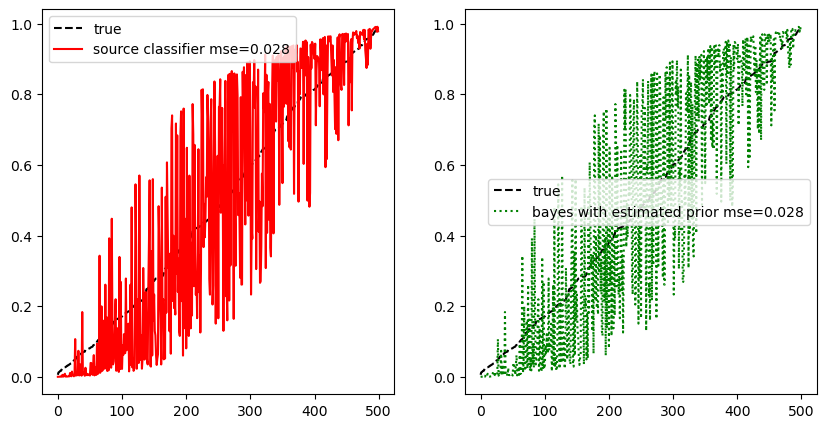

In [45]:

compare_methods_separate(Xtarget, prior_target, lik_fn_true, prior_source_est, lik_fn_est, classifier, meta_params)